<a href="https://colab.research.google.com/github/OtolaHan/Otola_Han_KAAN/blob/main/hometask_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Домашняя работа 4.

Максимальный балл за задание - 10.

## Данные


В этой домашней работе мы будем обучать модели машинного обучения, ставить эксперименты, подбирать гиперпараметры, сравнивать и смешивать модели. Вам предлагается решить задачу бинарной классификации, а именно построить алгоритм, определяющий превысит ли средний заработок человека порог $50k. Каждый объект выборки — человек, для которого известны следующие признаки:
 - age
 - workclass
 - fnlwgt
 - education
 - education-num
 - marital-status
 - occupation
 - relationship
 - race
 - sex
 - capital-gain
 - capital-loss
 - hours-per-week

Более подробно про признаки можно почитать [здесь](http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names). Целевой признак записан в переменной *>50K,<=50K*.

## Метрика качества

В задании мы будем оценивать качество моделей с помощью метрики AUC-ROC.

## Подбор гиперпараметров модели

В задачах машинного обучения следует различать параметры модели и гиперпараметры (структурные параметры). Обычно параметры модели настраиваются в ходе обучения (например, веса в линейной модели или структура решающего дерева), в то время как гиперпараметры задаются заранее (например, регуляризация в линейной модели или максимальная глубина решающего дерева). Каждая модель обычно имеет множество гиперпараметров, и нет универсальных наборов гиперпараметров, оптимально работающих во всех задачах, для каждой задачи нужно подбирать свой набор.

Для оптимизации гиперпараметров модели часто используют _перебор по сетке (grid search)_: для каждого гиперпараметра выбирается несколько значений, перебираются все комбинации значений и выбирается комбинация, на которой модель показывает лучшее качество (с точки зрения метрики, которая оптимизируется). Однако в этом случае нужно грамотно оценивать построенную модель, а именно делать разбиение на обучающую и тестовую выборку. Есть несколько схем, как это можно реализовать:

 - Разбить имеющуюся выборку на обучающую и тестовую. В этом случае сравнение большого числа моделей при переборе параметров приводит к ситуации, когда лучшая на тестовой подвыборке модель не сохраняет свои качества на новых данных. Можно сказать, что происходит _переобучение_ на тестовую выборку.
 - Для устранения описанной выше проблемы, можно разбить данные на 3 непересекающихся подвыборки: обучение (`train`), валидация (`validation`) и контроль (`test`). Валидационную подвыборку используют для сравнения моделей, а `test` — для окончательной оценки качества и сравнения семейств моделей с подобранными параметрами.
 - Другой способ сравнения моделей — [кросс-валидация](http://en.wikipedia.org/wiki/Cross-validation_(statistics). Существуют различные схемы кросс-валидации:
  - Leave-One-Out
  - K-Fold
  - Многократное случайное разбиение выборки
  
Кросс-валидация вычислительно затратна, особенно если вы делаете перебор по сетке с очень большим числом комбинации. С учетом конечности времени на выполнение задания, возникает ряд компромиссов:
  - сетку можно делать более разреженной, перебирая меньше значений каждого параметра; однако, надо не забывать, что в таком случае можно пропустить хорошую комбинацию параметров;
  - кросс-валидацию можно делать с меньшим числом разбиений или фолдов, но в таком случае оценка качества кросс-валидации становится более шумной и увеличивается риск выбрать неоптимальный набор параметров из-за случайности разбиения;
  - параметры можно оптимизировать последовательно (жадно) — один за другим, а не перебирать все комбинации; такая стратегия не всегда приводит к оптимальному набору;
  - перебирать не все комбинации параметров, а небольшое число случайно выбранных.

## Задание

Загрузите набор данных *data.adult.csv*. Чтобы лучше понимать, с чем вы работаете/корректно ли вы загрузили данные можно вывести несколько первых строк на экран.

In [7]:
import pandas as pd

data = pd.read_csv('data.adult.csv')

print(data.head())

   age  workclass  fnlwgt     education  education-num      marital-status  \
0   34  Local-gov  284843       HS-grad              9       Never-married   
1   40    Private  190290  Some-college             10            Divorced   
2   36  Local-gov  177858     Bachelors             13  Married-civ-spouse   
3   22    Private  184756  Some-college             10       Never-married   
4   47    Private  149700     Bachelors             13  Married-civ-spouse   

        occupation   relationship   race     sex  capital-gain  capital-loss  \
0  Farming-fishing  Not-in-family  Black    Male           594             0   
1            Sales  Not-in-family  White    Male             0             0   
2   Prof-specialty      Own-child  White    Male             0             0   
3            Sales      Own-child  White  Female             0             0   
4     Tech-support        Husband  White    Male         15024             0   

   hours-per-week >50K,<=50K  
0              60  

Иногда в данных встречаются пропуски. Как задаются пропуски обычно либо прописывается в описании к данным, либо просто на месте пропуска после чтения данных оказывается значение numpy.nan. Более подробно о работе с пропусками в Pandas можно прочитать например [здесь](http://pandas.pydata.org/pandas-docs/stable/missing_data.html).

В данном датасете пропущенные значения обозначены как "?".

**Задание 1 (0.5 балла)** Найдите все признаки, имеющие пропущенные значения. Удалите из выборки все объекты с пропусками.

In [8]:
import pandas as pd
import numpy as np

# Загрузка данных в DataFrame 'df'
df = pd.read_csv('/content/data.adult.csv')

# Замена '?' на np.nan
df.replace("?", np.nan, inplace=True)

# Нахождение признаков с пропущенными значениями
features_with_missing_values = df.columns[df.isnull().any()].tolist()
print("Признаки с пропущенными значениями:", features_with_missing_values)

# Удаление объектов с пропусками
df.dropna(inplace=True)

# Выделение целевой переменной (предположим, что она называется 'target')
y = df['>50K,<=50K'].copy()

# Преобразование целевой переменной к бинарному формату
# Предположим, что положительный класс обозначается как 'positive'
y = (y == 'positive').astype(int)

# Удаление целевой переменной из датасета
df.drop('>50K,<=50K', axis=1, inplace=True)

# Выделение вещественных признаков (предположим, что они имеют тип float64)
real_features = df.select_dtypes(include=['float64']).copy()

# Теперь real_features содержит только вещественные признаки, y - целевая переменная

Признаки с пропущенными значениями: ['workclass', 'occupation']


Обычно после загрузки датасета всегда необходима его некоторая предобработка. В данном случае она будет заключаться в следующем:

 - Выделите целевую переменную в отдельную переменную, удалите ее из датасета и преобразуйте к бинарному формату.
 - Обратите внимание, что не все признаки являются вещественными. В начале мы будем работать только с вещественными признаками. Выделите их отдельно.

In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# Загрузка данных
data = pd.read_csv('data.adult.csv')

# Предобработка данных
# Преобразование категориальных переменных
ohe = OneHotEncoder(sparse_output=False)
cat_columns = data.select_dtypes(include=['object']).drop('>50K,<=50K', axis=1).columns
data_encoded = pd.DataFrame(ohe.fit_transform(data[cat_columns]))

# В зависимости от вашей версии scikit-learn используйте один из следующих вариантов:
# Для версии 0.22 и новее:
data_encoded.columns = ohe.get_feature_names_out(cat_columns)
# Для версии до 0.22:
# data_encoded.columns = ohe.get_feature_names()

data_numeric = data.drop(cat_columns, axis=1).drop('>50K,<=50K', axis=1)
data_preprocessed = pd.concat([data_numeric, data_encoded], axis=1)

# Целевая переменная
target = data['>50K,<=50K'].apply(lambda x: 1 if x == '>50K' else 0)

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(data_preprocessed, target, test_size=0.2, random_state=42)

# Продолжение работы с вещественными признаками
numerical_features = data.select_dtypes(include=['int64', 'float64'])

print(numerical_features.head())
# Далее следует выбор модели, обучение и оценка...


   age  fnlwgt  education-num  capital-gain  capital-loss  hours-per-week
0   34  284843              9           594             0              60
1   40  190290             10             0             0              40
2   36  177858             13             0             0              40
3   22  184756             10             0             0              30
4   47  149700             13         15024             0              40


## Обучение классификаторов на вещественных признаках

В данном разделе необходимо будет работать только с вещественными признаками и целевой переменной.

В начале посмотрим как работает подбор параметров по сетке и как влияет на качество разбиение выборки. Сейчас и далее будем рассматривать 5 алгоритмов:
 - [kNN](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
 - [DecisonTree](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)
 - [SGD Linear Classifier](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)
 - [RandomForest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
 - [GradientBoosting](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)

Для начала у первых трёх алгоритмов выберем один гиперпараметр, который будем оптимизировать:
 - kNN — число соседей (*n_neighbors*)
 - DecisonTree — глубина дерева (*max_depth*)
 - SGD Linear Classifier — оптимизируемая функция (*loss*)

Остальные параметры оставляйте в значениях по умолчанию. Для подбора гиперпараметров воспользуйтесь перебором по сетке, который реализован в классе [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). В качестве схемы кросс-валидации используйте 5-fold cv, которую можно задать с помощью класса [KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html).

**Задание 2 (1 балл)** Для каждого из первых трех алгоритмов подберите оптимальные значения указанных гиперпараметров. Для каждого из этих алгоритмов постройте график среднего качества по кросс-валидации при заданном значении гиперпараметра, на котором также отобразите доверительный интервал [m-std, m+std], где m - среднее, std - стандартное отклонение.

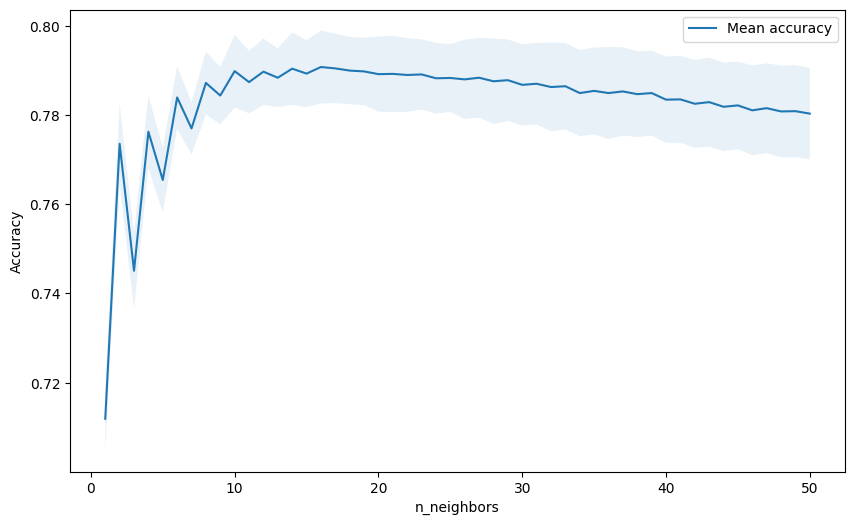

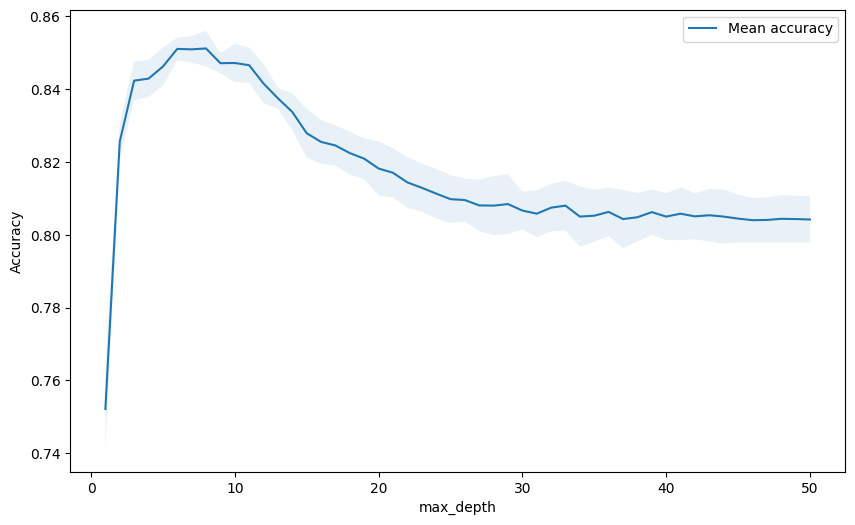

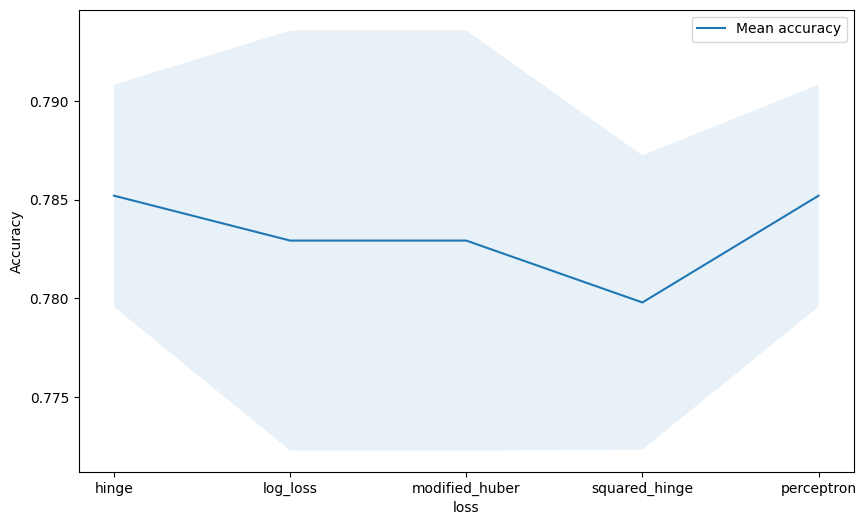

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier

# Подготовка данных: выбор только вещественных признаков
X_real = data_preprocessed.select_dtypes(include=[np.number])
y = target

# Схема кросс-валидации
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Параметры для GridSearchCV
param_grid_knn = {'n_neighbors': range(1, 51)}
param_grid_tree = {'max_depth': range(1, 51)}
param_grid_sgd = {'loss': ['hinge', 'log_loss', 'modified_huber', 'squared_hinge', 'perceptron']}

# Инициализация моделей
knn = KNeighborsClassifier()
decision_tree = DecisionTreeClassifier(random_state=42)
sgd = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)

# Обучение моделей с GridSearchCV
grid_search_knn = GridSearchCV(knn, param_grid_knn, cv=cv, scoring='accuracy')
grid_search_tree = GridSearchCV(decision_tree, param_grid_tree, cv=cv, scoring='accuracy')
grid_search_sgd = GridSearchCV(sgd, param_grid_sgd, cv=cv, scoring='accuracy')

grid_search_knn.fit(X_real, y)
grid_search_tree.fit(X_real, y)
grid_search_sgd.fit(X_real, y)

# Функция для построения графика
def plot_validation_curve(grid_search, param_name, param_range):
    mean_scores = grid_search.cv_results_['mean_test_score']
    std_scores = grid_search.cv_results_['std_test_score']

    plt.figure(figsize=(10, 6))
    plt.plot(param_range, mean_scores, label='Mean accuracy')
    plt.fill_between(param_range, mean_scores - std_scores, mean_scores + std_scores, alpha=0.1)
    plt.xlabel(param_name)
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Построение графиков
plot_validation_curve(grid_search_knn, 'n_neighbors', range(1, 51))
plot_validation_curve(grid_search_tree, 'max_depth', range(1, 51))
plot_validation_curve(grid_search_sgd, 'loss', ['hinge', 'log_loss', 'modified_huber', 'squared_hinge', 'perceptron'])

Что вы можете сказать о получившихся графиках?

**Задание 3 (0.5 балла)** Также подберём число деревьев (*n_estimators*) в алгоритме RandomForest. Как известно, в общем случае Random Forest не переобучается с увеличением количества деревьев, так что при увеличении этого гиперпараметра его качество не будет становиться хуже. Поэтому подберите такое количество деревьев, при котором качество на кросс-валидации стабилизируется. Обратите внимание, что для проведения этого эксперимента не нужно с нуля обучать много случайных лесов с различными количествами деревьев. Обучите один случайный лес с максимальным интересным количеством деревьев, а затем рассмотрите подмножества разных размеров, состоящие из деревьев построенного леса (поле [*estimators_*](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)). В дальнейших экспериментах используйте это количество деревьев.

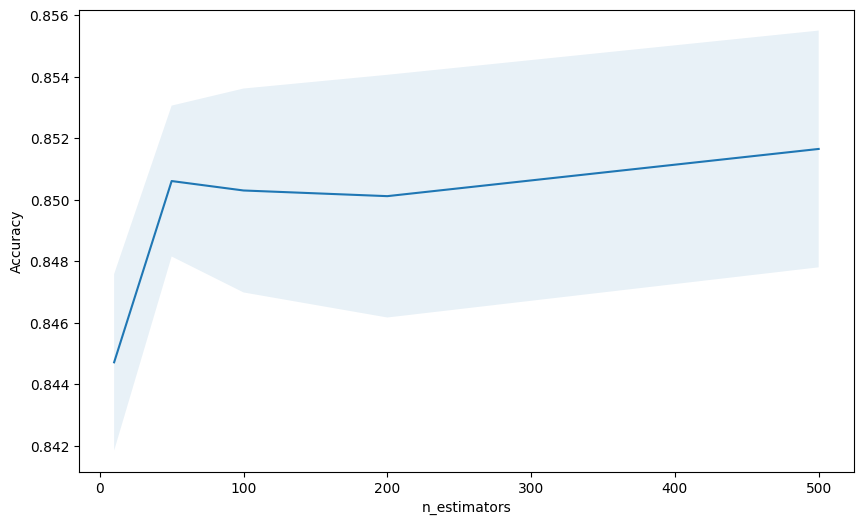

In [13]:
from sklearn.ensemble import RandomForestClassifier

# Параметры для RandomForest
param_grid_rf = {'n_estimators': [10, 50, 100, 200, 500]}

# Обучение модели RandomForest с GridSearchCV
random_forest = RandomForestClassifier(random_state=42)
grid_search_rf = GridSearchCV(random_forest, param_grid_rf, cv=cv, scoring='accuracy')
grid_search_rf.fit(X_real, y)

# Визуализация результатов
estimators_range = [10, 50, 100, 200, 500]
mean_scores_rf = grid_search_rf.cv_results_['mean_test_score']
std_scores_rf = grid_search_rf.cv_results_['std_test_score']

plt.figure(figsize=(10, 6))
plt.plot(estimators_range, mean_scores_rf)
plt.fill_between(estimators_range, mean_scores_rf - std_scores_rf,
                 mean_scores_rf + std_scores_rf, alpha=0.1)
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
plt.show()

**Задание 4 (0.5 балла)** Подберём число деревьев (*n_estimators*) в алгоритме GradientBoosting. Мы знаем, что ошибка бустинга на тестовых данных, как правило, имеет U-образную форму, то есть сначала уменьшается, а при достижении некоторого числа деревьев начинает расти. Нарисуйте график ошибки в зависимости от числа деревьев. Подберите n_estimators, соответствующий минимуму ошибки.

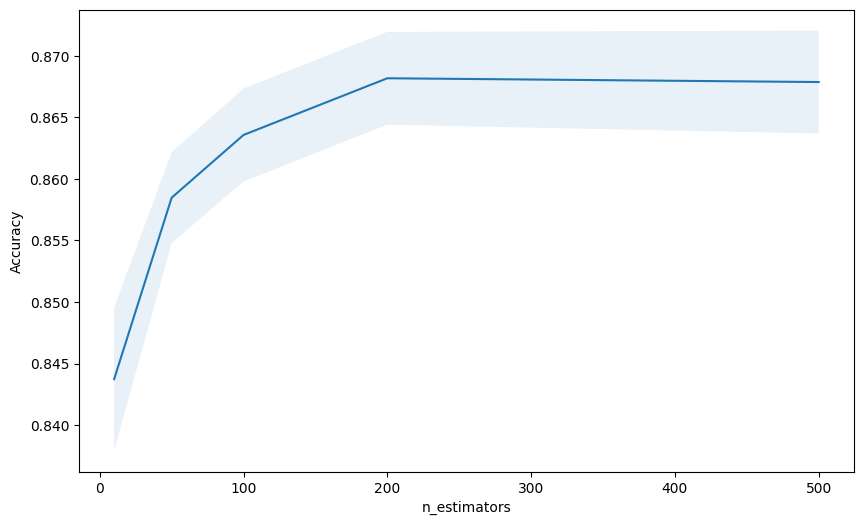

In [14]:
from sklearn.ensemble import GradientBoostingClassifier

# Параметры для GradientBoosting
param_grid_gb = {'n_estimators': [10, 50, 100, 200, 500]}

# Обучение модели GradientBoosting с GridSearchCV
gradient_boosting = GradientBoostingClassifier(random_state=42)
grid_search_gb = GridSearchCV(gradient_boosting, param_grid_gb, cv=cv, scoring='accuracy')
grid_search_gb.fit(X_real, y)

# Визуализация результатов
mean_scores_gb = grid_search_gb.cv_results_['mean_test_score']
std_scores_gb = grid_search_gb.cv_results_['std_test_score']

plt.figure(figsize=(10, 6))
plt.plot(estimators_range, mean_scores_gb)
plt.fill_between(estimators_range, mean_scores_gb - std_scores_gb,
                 mean_scores_gb + std_scores_gb, alpha=0.1)
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
plt.show()

При обучении алгоритмов стоит обращать внимание не только на качество, но и каким образом они работают с данными. В этой задаче получилось так, что некоторые из используемых алгоритмов чувствительны к масштабу признаков. Чтобы убедиться, что это как-то могло повлиять на качество давайте посмотрим на сами признаки.

**Задание 5 (0.5 балла)** Постройте гистограммы для признаков *age*, *fnlwgt*, *capital-gain*. Глядя на получившиеся графики в чем заключается особенность данных? На какие алгоритмы это может повлиять? Может ли масшитабирование повлиять на работу этих алгоритмов?

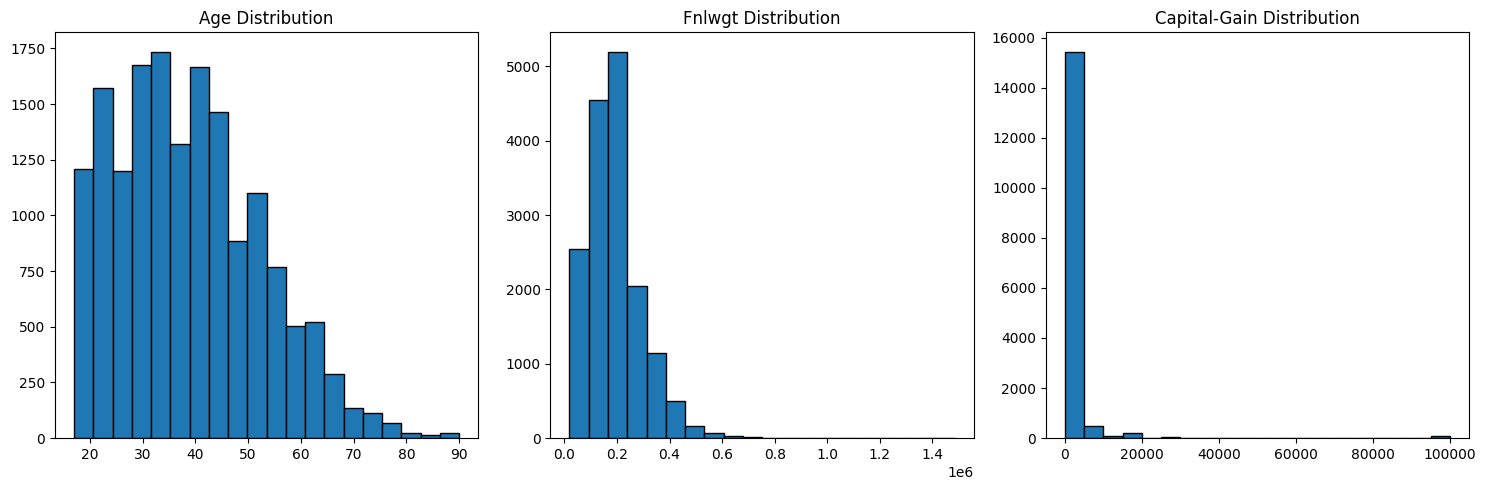

In [15]:
import matplotlib.pyplot as plt

# Построение гистограмм для признаков age, fnlwgt, capital-gain
plt.figure(figsize=(15, 5))

# Гистограмма для age
plt.subplot(1, 3, 1)
plt.hist(data_preprocessed['age'], bins=20, edgecolor='k')
plt.title('Age Distribution')

# Гистограмма для fnlwgt
plt.subplot(1, 3, 2)
plt.hist(data_preprocessed['fnlwgt'], bins=20, edgecolor='k')
plt.title('Fnlwgt Distribution')

# Гистограмма для capital-gain
plt.subplot(1, 3, 3)
plt.hist(data_preprocessed['capital-gain'], bins=20, edgecolor='k')
plt.title('Capital-Gain Distribution')

plt.tight_layout()
plt.show()

Масштабирование признаков можно выполнить, например, одним из следующих способов способами:
 - $x_{new} = \dfrac{x - \mu}{\sigma}$, где $\mu, \sigma$ — среднее и стандартное отклонение значения признака по всей выборке (см. функцию [scale](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.scale.html))
 - $x_{new} = \dfrac{x - x_{min}}{x_{max} - x_{min}}$, где $[x_{min}, x_{max}]$ — минимальный интервал значений признака

Похожие схемы масштабирования приведены в классах [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler) и [MinMaxScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler).

**Задание 6 (1 балл)** Масштабируйте все вещественные признаки одним из указанных способов и подберите оптимальные значения гиперпараметров аналогично пункту выше.

Лучшее значение параметра n_neighbors для kNN: {'n_neighbors': 31}


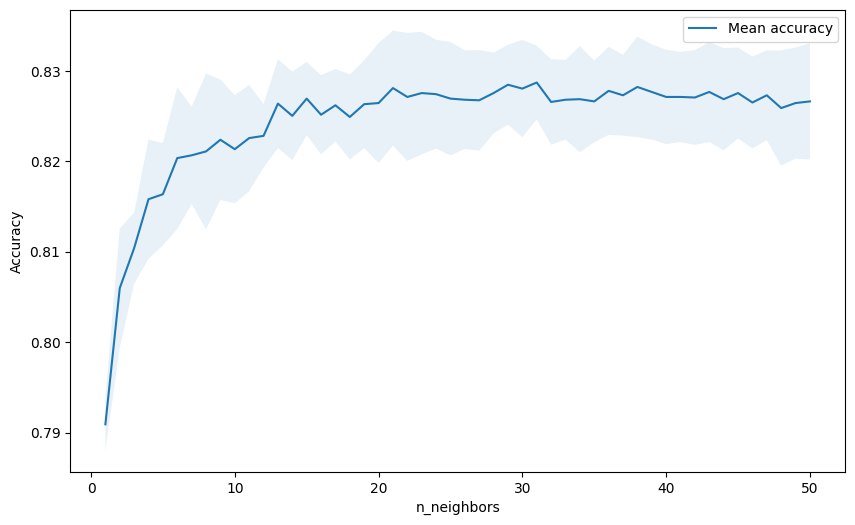

In [16]:
from sklearn.preprocessing import StandardScaler

# Масштабирование всех вещественных признаков
scaler = StandardScaler()
X_real_scaled = scaler.fit_transform(X_real)

# Подбор оптимальных значений гиперпараметров для kNN (пример)
grid_search_knn.fit(X_real_scaled, y)
print("Лучшее значение параметра n_neighbors для kNN:", grid_search_knn.best_params_)

# Проверка изменения качества для kNN
plot_validation_curve(grid_search_knn, 'n_neighbors', range(1, 51))

Изменилось ли качество у некоторых алгоритмов?

**Задание 7 (1.25 балла)** Теперь сделайте перебор нескольких гиперпараметров по сетке и найдите оптимальные комбинации (лучшее среднее значение качества) для каждого алгоритма в данном случае:
 - KNN — число соседей (*n_neighbors*) и метрика (*metric*)
 - DecisonTree — глубина дерева (*max_depth*) и критерий разбиения (*criterion*)
 - RandomForest — критерий разбиения в деревьях (*criterion*) и *max_features* (при фиксированном количестве деревьев, найденном ранее)
 - GradientBoosting — критерий разбиения в деревьях (*criterion*) и *max_features* (при фиксированном количестве деревьев, найденном ранее)
 - SGDClassifier — оптимизируемая функция (*loss*) и *penalty*

Обратите внимание, что эта операция может быть ресурсо- и трудоемкой. Как оптимизировать подбор параметров по сетке сказано в разделе "Подбор гиперпараметров модели"

In [17]:
# Пример поиска оптимального количества деревьев для RandomForest
param_grid_rf = {
    'n_estimators': [50, 100, 200, 300],
    'criterion': ['gini', 'entropy'],
    'max_features': [1.0, 'sqrt', 'log2']
}
rf = RandomForestClassifier(random_state=42)
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=cv, scoring='accuracy')
grid_search_rf.fit(X_real_scaled, y)

# Получаем лучшее количество деревьев из результатов GridSearchCV
best_n_estimators = grid_search_rf.best_params_['n_estimators']
print("Лучшее количество деревьев для RandomForest:", best_n_estimators)

Лучшее количество деревьев для RandomForest: 100


In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

# Пример перебора нескольких гиперпараметров для KNN
param_grid_knn = {'n_neighbors': range(1, 51, 5), 'metric': ['euclidean', 'manhattan']}
grid_search_knn = GridSearchCV(knn, param_grid_knn, cv=cv, scoring='accuracy', n_jobs=-1)
grid_search_knn.fit(X_real_scaled, y)
print("Лучшие параметры для KNN:", grid_search_knn.best_params_)

# DecisionTree
param_grid_dt = {
    'max_depth': range(1, 11),
    'criterion': ['gini', 'entropy']
}
dt = DecisionTreeClassifier(random_state=42)
grid_search_dt = GridSearchCV(dt, param_grid_dt, cv=cv, scoring='accuracy')
grid_search_dt.fit(X_real_scaled, y)
print("Лучшие параметры для DecisionTree:", grid_search_dt.best_params_)

# RandomForest (предположим, что best_n_estimators - это количество деревьев, найденное ранее)
param_grid_rf = {
    'n_estimators': [50, 100, 200, 300],
    'criterion': ['gini', 'entropy'],
    'max_features': [1.0, 'sqrt', 'log2']
}
rf = RandomForestClassifier(max_features=1.0, n_estimators=best_n_estimators, random_state=42)
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=cv, scoring='accuracy', n_jobs=-1)
grid_search_rf.fit(X_real_scaled, y)
print("Лучшие параметры для RandomForest:", grid_search_rf.best_params_)

# GradientBoosting
param_grid_gb = {
    'criterion': ['friedman_mse', 'squared_error'],
    'max_features': ['sqrt', 'log2']
}
gb = GradientBoostingClassifier(n_estimators=best_n_estimators, random_state=42)
grid_search_gb = GridSearchCV(gb, param_grid_gb, cv=cv, scoring='accuracy', n_jobs=-1)
grid_search_gb.fit(X_real_scaled, y)
print("Лучшие параметры для GradientBoosting:", grid_search_gb.best_params_)

# SGDClassifier
param_grid_sgd = {
    'loss': ['hinge', 'log_loss', 'modified_huber', 'squared_hinge', 'perceptron'],
    'penalty': ['l2', 'l1', 'elasticnet']
}
sgd = SGDClassifier(max_iter=2000, tol=1e-4, random_state=42)
grid_search_sgd = GridSearchCV(sgd, param_grid_sgd, cv=cv, scoring='accuracy', n_jobs=-1)
grid_search_sgd.fit(X_real_scaled, y)
print("Лучшие параметры для SGDClassifier:", grid_search_sgd.best_params_)

Лучшие параметры для KNN: {'metric': 'manhattan', 'n_neighbors': 36}
Лучшие параметры для DecisionTree: {'criterion': 'gini', 'max_depth': 8}
Лучшие параметры для RandomForest: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 100}
Лучшие параметры для GradientBoosting: {'criterion': 'friedman_mse', 'max_features': 'sqrt'}
Лучшие параметры для SGDClassifier: {'loss': 'log_loss', 'penalty': 'l1'}


Какой из алгоритмов имеет наилучшее качество?

**Задание 8 (0.5 балла)** Сравните алгоритмы с точки зрения времени обучения. Обучение какого из алгоритмов работает дольше всего и, как вы думаете, почему?

## Добавление категориальных признаков в модели

Пока мы не использовали нечисловые признаки, которые есть в датасете. Давайте посмотрим, правильно ли мы сделали и увеличится ли качество моделей после добавлениях этих признаков.

**Задание 9 (0.5 балла)** Преобразуйте все категориальные признаки с помощью метода one-hot-encoding (например, это можно сделать с помощью функции [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html), [pandas.get_dummies](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html) или [DictVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.DictVectorizer.html) из sklearn).

In [19]:
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

# Загрузка данных
df = pd.read_csv('/content/data.adult.csv')

# Кодирование категориальных признаков
categorical_features = df.select_dtypes(include=['object']).columns
df_encoded = pd.get_dummies(df, columns=categorical_features)

# Определение признаков и целевой переменной
X = df_encoded.drop(['>50K,<=50K_<=50K', '>50K,<=50K_>50K'], axis=1)
y = df_encoded['>50K,<=50K_>50K']


**Задание 10 (0.5 балла)** Добавьте к масштабированным вещественным признакам закодированные категориальные и обучите алгоритмы с наилучшими гиперпараметрами из предыдущего пункта. Дало ли добавление новых признаков прирост качества? Измеряйте качество как и раньше используя 5-Fold CV. Для этого удобно воспользоваться функцией [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html).

In [20]:
best_params_dt = grid_search_dt.best_params_
dt = DecisionTreeClassifier(**best_params_dt)

# Обучение модели и оценка качества с использованием перекрестной проверки
cv_scores = cross_val_score(dt, X, y, cv=5, scoring='accuracy')

print("Средняя точность DecisionTree с новыми признаками:", cv_scores.mean())

Средняя точность DecisionTree с новыми признаками: 0.8493857493857494


Отличается ли теперь наилучший классификатор от наилучшего в предыдущем пункте?

## Поиск новых полезных признаков

**Задание 11 (1.25 балла).** Попробуем улучшить качество модели, добавив в неё новые информативные признаки. Поступим так же, как действовали на [семинаре](https://github.com/Murcha1990/ML_Econom_2021-2022/blob/main/Семинары/Семинар%207/Seminar7.ipynb):
* добавьте к модели полиномиальных признаков степени 2 (для создания полиномиальных признаков используйте только исходные числовые признаки)
* затем снизьте размерность с помощью:
a) фильтрационных методов
b) жадного отбора признаков (RFE)
с) встроенного в модель метода отбора признаков.

Для каждого пункта выше выберите один метод и подберите для него оптимальные гиперпараметры, а также количество финальных признаков (по кросс-валидации).

* Затем можно добавить к модели закодированные в предыдущем пункте категориальные признаки.

Позволил ли этот подход улучшить качество моделей?

In [26]:
from sklearn.preprocessing import PolynomialFeatures

# Создание полиномиальных признаков степени 2
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)


In [40]:
from sklearn.feature_selection import SelectKBest, f_classif
import numpy as np
from sklearn.feature_selection import VarianceThreshold

# Удаление признаков с нулевой дисперсией
sel = VarianceThreshold(threshold=0)
X_poly_non_const = sel.fit_transform(X_poly)

# Проверка на NaN и бесконечные значения
X_poly_non_const = np.nan_to_num(X_poly_non_const)

# Теперь можно применять SelectKBest
selector = SelectKBest(f_classif, k=10)
X_reduced = selector.fit_transform(X_poly_non_const, y)


In [42]:
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier

estimator = DecisionTreeClassifier(max_depth=5, random_state=42)
selector = RFE(estimator, n_features_to_select=10, step=5)
X_reduced = selector.fit_transform(X_poly, y)

In [43]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_poly, y)

importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

# Выберем топ-N наиболее важных признаков
N = 10
top_indices = indices[:N]
X_reduced = X_poly[:, top_indices]

## Смешивание моделей

Во всех предыдущих пунктах мы получили много сильных моделей, которые могут быть достаточно разными по своей природе (например, метод ближайших соседей и случайный лес). Часто на практике оказывается возможным увеличить качество предсказания путем смешивания подобных разных моделей. Давайте посмотрим, действительно ли это дает прирост в качестве.

Выберите из построенных моделей двух предыдущих пунктов две, которые дали наибольшее начество на кросс-валидации (обозначим их $clf_1$ и $clf_2$). Далее постройте новый классификатор, ответ которого на некотором объекте $x$ будет выглядеть следующим образом:

$$result(x) = clf_1(x) \cdot \alpha + clf_2(x) \cdot (1 - \alpha)$$

где $\alpha$ — гиперпараметр нового классификатора.

**Задание 12 (1 балл)** Подберите по сетке от 0 до 1 $\alpha$ для этого классификатора с помощью 5-Fold CV и постройте график качества в зависимости от $\alpha$ (аналогичный графику в разделе "Обучение классификаторов и оценка качества"). Дал ли этот подход прирост к качеству по сравнению с моделями ранее?

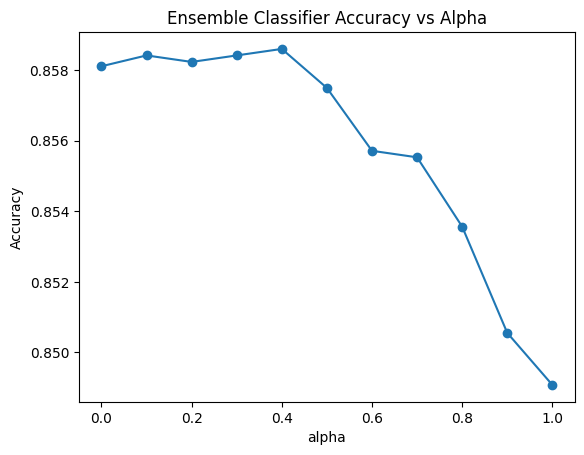

Лучшее значение alpha: 0.4, максимальная точность: 0.8585995085995087
Точность RandomForestClassifier: 0.8490786240786242
Точность GradientBoostingClassifier: 0.8581081081081081


In [54]:
import numpy as np
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, ClassifierMixin

# Предположим, что clf1 и clf2 - это два классификатора с лучшими параметрами,
# найденными с помощью GridSearchCV.
clf1 = RandomForestClassifier(**grid_search_rf.best_params_, random_state=42)
clf2 = GradientBoostingClassifier(**grid_search_gb.best_params_, random_state=42)

# Обучаем обе модели на полном обучающем наборе данных
clf1.fit(X_real_scaled, y)
clf2.fit(X_real_scaled, y)

# Диапазон значений для параметра α
alpha_range = np.linspace(0, 1, 11)

# Список для хранения средних оценок точности
cv_scores = []

class BlendedClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, clf1, clf2, alpha=0.5):  # Исправлено на __init__
        self.clf1 = clf1
        self.clf2 = clf2
        self.alpha = alpha

    def fit(self, X, y):
        self.clf1.fit(X, y)
        self.clf2.fit(X, y)
        return self

    def predict(self, X):
        pred1 = self.clf1.predict_proba(X)[:, 1]
        pred2 = self.clf2.predict_proba(X)[:, 1]
        blended_pred = self.alpha * pred1 + (1 - self.alpha) * pred2
        return np.round(blended_pred)

    def predict_proba(self, X):
        pred1 = self.clf1.predict_proba(X)[:, 1]
        pred2 = self.clf2.predict_proba(X)[:, 1]
        return np.vstack(((1 - self.alpha) * pred1 + self.alpha * pred2,
                          self.alpha * pred1 + (1 - self.alpha) * pred2)).T

# Теперь мы можем использовать BlendedClassifier как обычный оценщик
for alpha in alpha_range:
    ensemble = BlendedClassifier(clf1=clf1, clf2=clf2, alpha=alpha)
    score = cross_val_score(ensemble, X_real_scaled, y, cv=5, scoring='accuracy').mean()
    cv_scores.append(score)

# Вывод графика зависимости точности от α
plt.plot(alpha_range, cv_scores, marker='o')
plt.xlabel('alpha')
plt.ylabel('Accuracy')
plt.title('Ensemble Classifier Accuracy vs Alpha')
plt.show()

# Находим лучшее значение alpha и максимальную точность
best_alpha = alpha_range[np.argmax(cv_scores)]
best_score = np.max(cv_scores)
print(f"Лучшее значение alpha: {best_alpha}, максимальная точность: {best_score}")

# Сравнение с точностью отдельных моделей
print(f"Точность RandomForestClassifier: {cross_val_score(clf1, X_real_scaled, y, cv=5, scoring='accuracy').mean()}")
print(f"Точность GradientBoostingClassifier: {cross_val_score(clf2, X_real_scaled, y, cv=5, scoring='accuracy').mean()}")

## Сравнение построенных моделей

![](http://cdn.shopify.com/s/files/1/0870/1066/files/compare_e8b89647-3cb6-4871-a976-2e36e5987773.png?1750043340268621065)

После того как было построено много моделей хотелось бы сравнить их между собой. Для этого можно построить "ящик с усами" (диаграму размаха). Для этого можно воспользоваться библиотекой [matplotlib](https://matplotlib.org/3.1.0/api/_as_gen/matplotlib.pyplot.boxplot.html) или [seaborn](https://seaborn.pydata.org/generated/seaborn.boxplot.html).

**Задание 13 (1 балл)** Для каждого типа классификатора (kNN, DecisionTree, RandomForest, SGD classifier), а так же смешанной модели выберите тот, которых давал наилучшее качество на кросс-валидации (с учетом подобранных гиперпараметров) и постройте диаграмму размаха (все классификаторы должны быть изображены на одном графике).

Сделайте общие итоговые выводы о классификаторах с точки зрения их работы с признаками и сложности самой модели (какие гиперпараметры есть у модели, сильно ли изменение значения гиперпараметра влияет на качество модели).

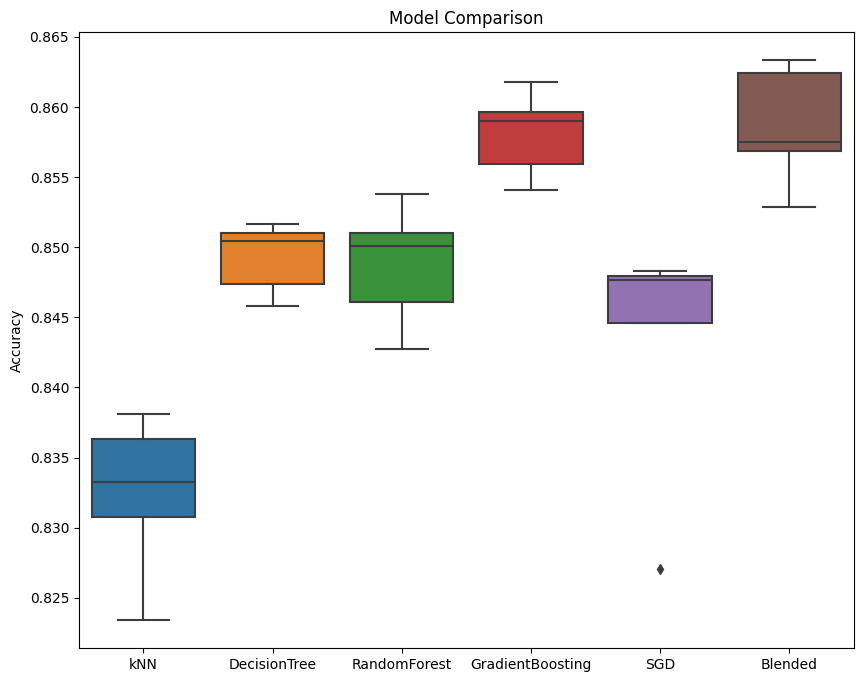

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score

# Список для хранения результатов кросс-валидации
results = []
names = []

# Функция для добавления результатов кросс-валидации в список
def add_model_scores(model, name, X, y):
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    results.append(cv_scores)
    names.append(name)

# Создайте модели с лучшими параметрами
knn_best = KNeighborsClassifier(**grid_search_knn.best_params_)
decision_tree_best = DecisionTreeClassifier(**grid_search_dt.best_params_)
random_forest_best = RandomForestClassifier(**grid_search_rf.best_params_)
gb_best = GradientBoostingClassifier(**grid_search_gb.best_params_)
sgd_best = SGDClassifier(**grid_search_sgd.best_params_)

# Создание экземпляра BlendedClassifier с лучшим alpha
blended_best = BlendedClassifier(clf1=clf1, clf2=clf2, alpha=best_alpha)

# Теперь передайте эти модели в функцию add_model_scores
add_model_scores(knn_best, 'kNN', X_real_scaled, y)
add_model_scores(decision_tree_best, 'DecisionTree', X_real_scaled, y)
add_model_scores(random_forest_best, 'RandomForest', X_real_scaled, y)
add_model_scores(gb_best, 'GradientBoosting', X_real_scaled, y)
add_model_scores(sgd_best, 'SGD', X_real_scaled, y)
add_model_scores(blended_best, 'Blended', X_real_scaled, y)

# Создаем DataFrame для удобства построения диаграммы размаха
import pandas as pd
all_scores = pd.DataFrame(columns=names)
for i in range(len(names)):
    all_scores[names[i]] = results[i]

# Строим диаграмму размаха
plt.figure(figsize=(10, 8))
sns.boxplot(data=all_scores)
plt.title('Model Comparison')
plt.ylabel('Accuracy')
plt.show()

